# Use SurvivalEVAL for PySurvival and auton-survival models

In this notebook we introduce the use of `SurvivalEvaluator` in the package to evaluate the performance for a `PySurvival` and [`auton-survival`](https://autonlab.org/auton-survival/) model.

**Note that the `PySurvival` package is no longer maintained and only support until Python 3.7**. Therefore, this evaluation package has deprecated the support for `PySurvival` models. 

If you are interested in some survival models implemented in the `PySurvival` package, you can find all those models in other packages:
- `Cox Proportional Hazard` model: you can use the `lifelines` package or `scikit-survival` package.
- Linear and Neural `Multi-task Logistic Regression` models: you can use the [`torchmtlr`](https://github.com/mkazmier/torchmtlr) package. 
    - Also, the MTLR model in `PySurvival` has problem of convergence (due to the incorrect implementation of the loss function) and the `torchmtlr` package has fixed this problem.
- Parametric models (exponential, Weibull, etc): you can use the `lifeline` package.
- Survival trees and forests: you can use the `scikit-survival` package.

However, if you still prefer to use the `PySurvival` package, this tutorial will guide you through the evaluation process, with the assumption that you have already familiar with the training step for the `PySurvival` package.

In the following, we will:
1. Load the GBSG dataset;
2. Train the `DeepSurvivalMachines` model;
3. Perform evaluation on the 30% testing set.

As the `PySurvival` and `auton-survival` models have the similar data structure for the predicted survival curves. If you are using the `PySurvival` package, you can skip the first two steps and directly go to the [third step](#3-perform-evaluation-on-the-testing-set).

## 1. Load the dataset

In [1]:
from lifelines.datasets import load_gbsg2
# Load the data and split train/test set
gbsg2 = load_gbsg2()
gbsg2 = gbsg2.replace({"horTh": {"no": 0, "yes": 1}, "menostat": {"Pre": 0, "Post": 1}, "tgrade": {"I": 1, "II": 2, "III": 3}})
train, test = gbsg2.iloc[:400, :], gbsg2.iloc[400:, :]

x_train, x_test = train.drop(["time", "cens"], axis=1).astype(float), test.drop(["time", "cens"], axis=1).astype(float)
t_train, t_test = train["time"], test["time"]
e_train, e_test = train["cens"], test["cens"]

## 2. Train the model

In [2]:
from auton_survival import models

# Train a Deep Survival Machine (DSM) model
model = models.dsm.DeepSurvivalMachines(k=3, layers=[32, 32])
model.fit(x_train, t_train, e_train)

100%|██████████| 1/1 [00:00<00:00, 90.47it/s]


## 3. Perform evaluation on the testing set
Let first make the predictions on the testing set. 

In [3]:
import numpy as np

t_max = t_train.max()

# make a list of 100 uniform time points from 0 to t_max
# Any monotonic increasing time points can be used here
time_coordinates = np.linspace(0, t_max, 100).tolist()

# make predictions
predictions = model.predict_survival(x_test, t=time_coordinates)

This is for `PySurvival` users, you should build your model and start from here by ignoring the above cells and uncommenting the following lines.

In [4]:
# survival_curves = model.predict_survival(X, None)
# time_coordinates = model.times

In [5]:
from Evaluator import SurvivalEvaluator

evaler = SurvivalEvaluator(predictions, time_coordinates, t_test, e_test, t_train, e_train)

The rest of the evaluation process is the same as the other tutorials. 

For the sake of completeness, we will repeat a brief example of the evaluation process. You can find more details ones in the [PyCox example](https://github.com/shi-ang/SurvivalEVAL/blob/main/Examples/Pycox_Example.ipynb) and [scikit-survival example](https://github.com/shi-ang/SurvivalEVAL/blob/main/Examples/Scikit-survival_Example.ipynb).

## Calculate the concordance index.

In [6]:
cindex, concordant_pairs, total_pairs = evaler.concordance(ties="None")
print("Concordance index is {}, meaning that the model can correctly order {} pairs among {} comparable pairs "
      "in the testing set.".format(cindex, concordant_pairs, total_pairs))

Concordance index is 0.6124070232252189, meaning that the model can correctly order 12103.0 pairs among 19763.0 comparable pairs in the testing set.


Calculate the integrated Brier score (IBS)

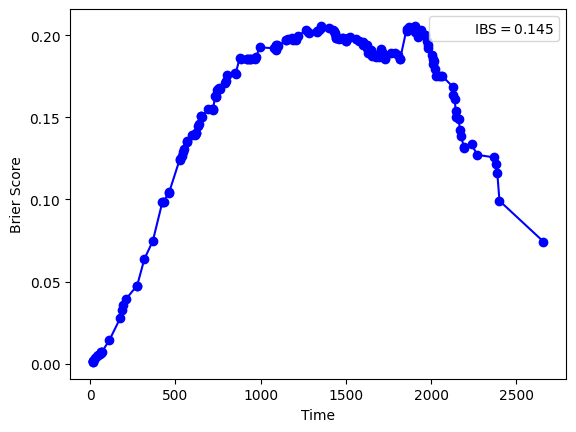

Integrated Brier score is 0.144790156076693.


In [7]:
ibs = evaler.integrated_brier_score(num_points=None, IPCW_weighted=True, draw_figure=True)
print("Integrated Brier score is {}.".format(ibs))

Calculate the MAE-PO (Pseudo observation) score

In [8]:
mae_score = evaler.mae(method='Pseudo_obs')
print("MAE-PO loss is {}.".format(mae_score))

MAE-PO loss is 1273.1081672393984.


Calculate the distribution calibration (D-Calibration)

In [9]:
p_value, bin_statistics = evaler.d_calibration()
if p_value >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")

The model is not d-calibrated!
